# Моделирование


In [1]:
import time
import warnings
import shap
import joblib
import optuna
import optuna.logging
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns  
from IPython.display import Markdown

from sklearn.model_selection import train_test_split 
from sklearn.metrics import make_scorer 

from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# DATA_PATH = "C:\\Users\\Natalia\\Desktop\\Lenta_YM\\sp_sales_task\\"

In [5]:
# top_50_rub_data = pd.read_csv(f"{DATA_PATH}top_50_rub_data.csv")
# top_25_rub_data = pd.read_csv(f"{DATA_PATH}top_25_rub_data.csv")
# sales_submission = pd.read_csv(f"{DATA_PATH}sales_submission.csv") 

In [6]:
top_50_rub_data = pd.read_csv("top_50_rub_data.csv")
sales_submission = pd.read_csv("sales_submission.csv") 
top_25_rub_data = pd.read_csv("top_25_rub_data.csv")

In [7]:
top_50_rub_data['date'] = pd.to_datetime(top_50_rub_data['date'])
since = top_50_rub_data['date'].min().date()
to = top_50_rub_data['date'].max().date()
print('Временной период: от {} до {} ({} дней)'.format(since, to, (to-since).days+1))

Временной период: от 2022-08-01 до 2023-07-18 (352 дней)


In [8]:
top_50_rub_data = top_50_rub_data.set_index('date')

In [9]:
top_50_rub_data.sort_index(inplace = True)

На предыдущей итерации проекта модель была обучена на всех признаках исходного датасета. Оценка важности признаков по SHAP показала, что ряд признаков не имеет никакого влияния, и если их удалить, то скорость обучения модели вырастает примерно в 5 раз (время обучения сократилось с 49 минут до 9 минут), а метрика улучается на 5%. 

Потому я удаляю признаки 'average_prices', 'pr_cat_id', 'st_division_code', 'pr_group_id', 'st_city_id', 'pr_subcat_id' в данном варианте работы. 

Также я удаляю выручку 'pr_sales_in_rub', поскольку она связана с обьемом продаж, а значит в дальнейчем мы ее рассчитать не сможем для теста. Кроме того, с ней модель переобучается. 

In [10]:
top_50_rub_data = top_50_rub_data.drop([
    'pr_sales_in_rub', 'average_prices', 'pr_cat_id', 'st_division_code', 
    'pr_group_id', 'st_city_id', 'pr_subcat_id'], axis=1)
top_50_rub_data.head()

,st_id,pr_sku_id,pr_sales_in_units,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,13.0,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,2.0,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,3.0,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,12.0,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,31.0,0,1,1,1,8,144.064516


In [11]:
top_50_rub_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59786 entries, 2022-08-01 to 2023-07-18
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   st_id              59786 non-null  object 
 1   pr_sku_id          59786 non-null  object 
 2   pr_sales_in_units  59786 non-null  float64
 3   holiday            59786 non-null  int64  
 4   pr_uom_id          59786 non-null  int64  
 5   st_type_format_id  59786 non-null  int64  
 6   st_type_loc_id     59786 non-null  int64  
 7   st_type_size_id    59786 non-null  int64  
 8   product_price      59786 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 4.6+ MB


Для работы с CatBoostRegression меняем категорию столбцов. CatBoost имеет встроеннй кодировщий, потому для данной модели мы будем использовать кодирование, но изменим object на category.

In [12]:
cat_features = ['st_id', 'pr_sku_id']
for col in cat_features:
    top_50_rub_data[col] = top_50_rub_data[col].astype('category')

In [13]:
top_50_rub_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59786 entries, 2022-08-01 to 2023-07-18
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   st_id              59786 non-null  category
 1   pr_sku_id          59786 non-null  category
 2   pr_sales_in_units  59786 non-null  float64 
 3   holiday            59786 non-null  int64   
 4   pr_uom_id          59786 non-null  int64   
 5   st_type_format_id  59786 non-null  int64   
 6   st_type_loc_id     59786 non-null  int64   
 7   st_type_size_id    59786 non-null  int64   
 8   product_price      59786 non-null  float64 
dtypes: category(2), float64(2), int64(5)
memory usage: 3.8 MB


## Подготовка

Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. 

WAPE (Weighted Absolute Percentage Error): WAPE представляет собой сумму абсолютных процентных ошибок между фактическими и предсказанными значениями, деленную на сумму абсолютных фактических значений.  

Напишем функцию расчета WAPE: 

In [14]:
def wape_calc(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

Для оценки моделей создадим метрики с помощью make_scorer:

In [15]:
wape_scorer = make_scorer(wape_calc, greater_is_better = False)

## Кросс-валидация 

В каждом разделе тестовые индексы должны быть выше, чем в предыдущем, и **поэтому перестановка в перекрестном валидаторе неуместна.**

Схема скользящее окно по кросс-валидации 
- Делим вручную на train, valid, test. Первая ступень 9 мес train, 14д valid, 14д test. Далее смещаемся на 14 дней (окно прогноза по ТЗ) вперед и получаем: 9мес+14д train, 14д valid, 14д test. 
- На train обучаем модели (например, мы захотели 12 бустингов), после на valid перебираем гиперпараметры, затем на train+valid обучаем лучший бустинг (лучшую модель). На test фиксируем метрику WAPE для лучшей модели. 
- Идем скользящим окном к следующей ступени и проводим те же операции. В результате получаем ряд метрик WAPE (в зависимости от количества фолдов). Можно усреднить WAPE по полученным значениям. 
- Также можно смотреть отношение valid WAPE/test WAPE и стараться максимизировать это значение. Это значение поможет понять, например, если модель переобучилась или не работоспособна на тесте. 
- Финальной выбираем модель, которая показала наилучший результат. Например, если лучшая модель - на первой ступени, то ее и берем. Можно брать сумму моделей или усреднение весов (больше train – больше вес). 
- Организаторы проверят модель на скрытом у них датасете, оценят WAPE и масштабируемость модели (скорость алгоритма).

### Подготовим выборки

**Создадим  пять тренировочных, валидационных и тестовых выборок с последовательно уменьшающимися датами, чтобы выполнить кросс-валидацию.** 

In [16]:
def split_time_series_auto_from_end(dataset, valid_days, test_days, num_sets=5):
    """
    Разделяет временной ряд на несколько тренировочных, валидационных и тестовых наборов данных от конечной даты.

    Args:
    - dataset: DataFrame с индексами, представляющими даты, и данными временного ряда.
    - valid_days: Количество дней для валидационного набора данных.
    - test_days: Количество дней для тестового набора данных.
    - num_sets: Количество тренировочных, валидационных и тестовых наборов.

    Returns:
    - train_sets: Список тренировочных наборов данных.
    - valid_sets: Список валидационных наборов данных.
    - test_sets: Список тестовых наборов данных.
    """

    dataset = dataset.sort_index()
    end_date = dataset.index[-1]

    train_sets = []
    valid_sets = []
    test_sets = []

    for _ in range(num_sets):
        # Определяем дату окончания для тестового набора
        test_end_date = end_date
        test_start_date = test_end_date - pd.DateOffset(days=test_days - 1)

        # Определяем дату окончания для валидационного набора
        valid_end_date = test_start_date - pd.DateOffset(days=1)
        valid_start_date = valid_end_date - pd.DateOffset(days=valid_days - 1)

        # Определяем дату окончания для тренировочного набора
        train_end_date = valid_start_date - pd.DateOffset(days=1)
        train_start_date = dataset.index[0]

        train_set = dataset[train_start_date:train_end_date]
        valid_set = dataset[valid_start_date:valid_end_date]
        test_set = dataset[test_start_date:test_end_date]

        train_sets.append(train_set)
        valid_sets.append(valid_set)
        test_sets.append(test_set)

        end_date = train_end_date - pd.DateOffset(days=1)

    return train_sets, valid_sets, test_sets

**Применим функцию к датасету и создадим списки train_sets, valid_sets и test_sets**

In [17]:
valid_days = 14
test_days = 14
num_sets = 5

train_sets, valid_sets, test_sets = split_time_series_auto_from_end(
    top_50_rub_data, valid_days, test_days, num_sets)

**Разделяем каждую выборку на признаки и целевую переменную для обучения, валидации и тестирования**

In [18]:
def split_datasets(train_sets, valid_sets, test_sets):
    """
    Разделяет каждую выборку на признаки и целевую переменную для обучения, валидации и тестирования.

    Args:
    - train_sets: Список тренировочных наборов данных.
    - valid_sets: Список валидационных наборов данных.
    - test_sets: Список тестовых наборов данных.

    Returns:
    - dataset_splits: Список кортежей, каждый из которых содержит кортеж с признаками и целевой переменной для
                     обучения, валидации и тестирования.
    """

    dataset_splits = []

    for train_set, valid_set, test_set in zip(train_sets, valid_sets, test_sets):
       
        features_train = train_set.drop('pr_sales_in_units', axis=1)
        target_train = train_set['pr_sales_in_units']

        features_valid = valid_set.drop('pr_sales_in_units', axis=1)
        target_valid = valid_set['pr_sales_in_units']

        features_test = test_set.drop('pr_sales_in_units', axis=1)
        target_test = test_set['pr_sales_in_units']

        dataset_splits.append((features_train, target_train, features_valid, target_valid, features_test, target_test))

    return dataset_splits

**У нас уже есть списки train_sets, valid_sets и test_sets, теперь создаем списки переменных для каждой выборки, которые содержат признаки и целевые признаки**

In [19]:
train_splits = []
valid_splits = []
test_splits = []

for train_set, valid_set, test_set in zip(train_sets, valid_sets, test_sets):
    # Разделяем каждую выборку на признаки и целевую переменную для обучения, валидации и тестирования
    dataset_splits = split_datasets([train_set], [valid_set], [test_set])
    
    # Разделяем результат на соответствующие переменные
    (features_train, target_train, features_valid, target_valid, features_test, target_test) = dataset_splits[0]

    # Добавляем полученные переменные в списки
    train_splits.append((features_train, target_train))
    valid_splits.append((features_valid, target_valid))
    test_splits.append((features_test, target_test))


**Выведем на экран полученные датасеты**, чтобы убедиться, что разделение прошло правильно 

In [20]:
def print_splits(split_list, split_type):
    for i, (features, target) in enumerate(split_list):
        print(f"Выборка {i + 1} ({split_type}):")
        print("Features:")
        display(features)
        print("Target:")
        display(target)
        print()

Выводим содержимое train_splits, valid_splits, test_splits

In [21]:
print_splits(train_splits, "Train")
print_splits(valid_splits, "Validation")
print_splits(test_splits, "Test")

Выборка 1 (Train):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,8,144.064516
...,...,...,...,...,...,...,...,...
2023-06-20,42a0e188f5033bc65bf8d78622277c4e,c0e3f3bd815a862433bc3399c487926b,0,1,1,1,12,124.658537
2023-06-20,42a0e188f5033bc65bf8d78622277c4e,71c9661741caf40a92a32d1cc8206c04,0,17,1,1,12,69.000000
2023-06-20,fa7cdfad1a5aaf8370ebeda47a1ff1c3,62d4af457ba2540ce0898a211c0cd17a,0,17,1,1,12,16.588235


Target:


date
2022-08-01    13.0
2022-08-01     2.0
2022-08-01     3.0
2022-08-01    12.0
2022-08-01    31.0
              ... 
2023-06-20    41.0
2023-06-20     1.0
2023-06-20    17.0
2023-06-20     2.0
2023-06-20    16.0
Name: pr_sales_in_units, Length: 54527, dtype: float64


Выборка 2 (Train):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,8,144.064516
...,...,...,...,...,...,...,...,...
2023-05-22,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6464ba75236f5928023d75e46ea8a328,0,1,1,1,12,725.500000
2023-05-22,16a5cdae362b8d27a1d8f8c7b78b4330,492f948808daf55a3f9e7ddd3694f546,0,1,1,2,8,347.000000
2023-05-22,c81e728d9d4c2f636f067f89cc14862c,492f948808daf55a3f9e7ddd3694f546,0,1,1,1,8,350.666667


Target:


date
2022-08-01    13.0
2022-08-01     2.0
2022-08-01     3.0
2022-08-01    12.0
2022-08-01    31.0
              ... 
2023-05-22     2.0
2023-05-22     2.0
2023-05-22     3.0
2023-05-22    14.0
2023-05-22     5.0
Name: pr_sales_in_units, Length: 49274, dtype: float64


Выборка 3 (Train):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,8,144.064516
...,...,...,...,...,...,...,...,...
2023-04-23,16a5cdae362b8d27a1d8f8c7b78b4330,17667b08596154dc5e9417f410cbced3,1,1,1,2,8,283.500000
2023-04-23,16a5cdae362b8d27a1d8f8c7b78b4330,4e824a65fbd01f1708131bd247842688,1,1,1,2,8,507.451613
2023-04-23,42a0e188f5033bc65bf8d78622277c4e,eb341a778d385ad6ebe16e90efb48c08,1,1,1,1,12,283.250000


Target:


date
2022-08-01    13.0
2022-08-01     2.0
2022-08-01     3.0
2022-08-01    12.0
2022-08-01    31.0
              ... 
2023-04-23     2.0
2023-04-23    31.0
2023-04-23     4.0
2023-04-23     5.0
2023-04-23    18.0
Name: pr_sales_in_units, Length: 44382, dtype: float64


Выборка 4 (Train):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,8,144.064516
...,...,...,...,...,...,...,...,...
2023-03-25,c81e728d9d4c2f636f067f89cc14862c,71c9661741caf40a92a32d1cc8206c04,1,17,1,1,8,81.750000
2023-03-25,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,1,1,1,1,8,191.769231
2023-03-25,f7e6c85504ce6e82442c770f7c8606f0,17667b08596154dc5e9417f410cbced3,1,1,1,1,12,385.666667


Target:


date
2022-08-01    13.0
2022-08-01     2.0
2022-08-01     3.0
2022-08-01    12.0
2022-08-01    31.0
              ... 
2023-03-25     4.0
2023-03-25    13.0
2023-03-25     3.0
2023-03-25     7.0
2023-03-25     6.0
Name: pr_sales_in_units, Length: 39275, dtype: float64


Выборка 5 (Train):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,0,1,1,1,12,133.384615
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,156.500000
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,58ebafabd92e2e3a80d86b7bb7e88eda,0,1,1,1,12,172.333333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,8,323.833333
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,8,144.064516
...,...,...,...,...,...,...,...,...
2023-02-24,fa7cdfad1a5aaf8370ebeda47a1ff1c3,67797f1f0f02ec5ccd5e3abd2d4e5b81,1,1,1,1,12,132.833333
2023-02-24,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b7e2077a3d7fa0d30e0eb5ec7fa349e8,1,1,1,1,12,275.200000
2023-02-24,c81e728d9d4c2f636f067f89cc14862c,c4a665596d4f67cecb7542c9fad407ee,1,1,1,1,8,141.000000


Target:


date
2022-08-01    13.0
2022-08-01     2.0
2022-08-01     3.0
2022-08-01    12.0
2022-08-01    31.0
              ... 
2023-02-24     6.0
2023-02-24     5.0
2023-02-24     4.0
2023-02-24     6.0
2023-02-24     2.0
Name: pr_sales_in_units, Length: 34474, dtype: float64


Выборка 1 (Validation):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-06-21,16a5cdae362b8d27a1d8f8c7b78b4330,364196813f3b746270a9b27bd76149c9,0,1,1,2,8,287.000000
2023-06-21,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,8,161.000000
2023-06-21,c81e728d9d4c2f636f067f89cc14862c,bf5f373eede102c71bf77874c78bdc59,0,1,1,1,8,205.000000
2023-06-21,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cf91eca9321c9c272fb4e7cf4bcc6a43,0,17,1,1,12,37.846154
2023-06-21,16a5cdae362b8d27a1d8f8c7b78b4330,cf91eca9321c9c272fb4e7cf4bcc6a43,0,17,1,2,8,41.096154
...,...,...,...,...,...,...,...,...
2023-07-04,c81e728d9d4c2f636f067f89cc14862c,5d560ea997068115892d2f0bd7cf91c3,0,1,1,1,8,184.400000
2023-07-04,fa7cdfad1a5aaf8370ebeda47a1ff1c3,a3f2130d312ab153ba470886115ea2ee,0,1,1,1,12,202.142857
2023-07-04,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9d678e20f4a45c137a0492034506d432,0,1,1,1,12,208.000000


Target:


date
2023-06-21     2.0
2023-06-21     4.0
2023-06-21     2.0
2023-06-21    13.0
2023-06-21    52.0
              ... 
2023-07-04     5.0
2023-07-04     7.0
2023-07-04     2.0
2023-07-04     6.0
2023-07-04    83.0
Name: pr_sales_in_units, Length: 2722, dtype: float64


Выборка 2 (Validation):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-05-23,6364d3f0f495b6ab9dcf8d3b5c6e0b01,62d4af457ba2540ce0898a211c0cd17a,0,17,1,1,12,16.470588
2023-05-23,16a5cdae362b8d27a1d8f8c7b78b4330,67dcedaa1090d67cef7afe3fb36945b0,0,1,1,2,8,156.625000
2023-05-23,c81e728d9d4c2f636f067f89cc14862c,fd55c4022acef4de4c7dc6cdd85a2d7a,0,17,1,1,8,58.361446
2023-05-23,f7e6c85504ce6e82442c770f7c8606f0,17667b08596154dc5e9417f410cbced3,0,1,1,1,12,358.000000
2023-05-23,6364d3f0f495b6ab9dcf8d3b5c6e0b01,67797f1f0f02ec5ccd5e3abd2d4e5b81,0,1,1,1,12,151.142857
...,...,...,...,...,...,...,...,...
2023-06-05,c81e728d9d4c2f636f067f89cc14862c,225de5ef23fbfa96f02a8e1e8626ab66,0,1,1,1,8,219.090909
2023-06-05,16a5cdae362b8d27a1d8f8c7b78b4330,1a0f36f6e92560bcae205b6c32cc033f,0,1,1,2,8,44.960000
2023-06-05,6364d3f0f495b6ab9dcf8d3b5c6e0b01,71c9661741caf40a92a32d1cc8206c04,0,17,1,1,12,80.000000


Target:


date
2023-05-23    17.0
2023-05-23     8.0
2023-05-23    83.0
2023-05-23     2.0
2023-05-23    14.0
              ... 
2023-06-05    11.0
2023-06-05    25.0
2023-06-05    37.0
2023-06-05     4.0
2023-06-05     1.0
Name: pr_sales_in_units, Length: 2638, dtype: float64


Выборка 3 (Validation):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-04-24,42a0e188f5033bc65bf8d78622277c4e,ced0c1a84924c982a6403870c54b99ca,0,17,1,1,12,36.210526
2023-04-24,6364d3f0f495b6ab9dcf8d3b5c6e0b01,777d21d980f82aa8b4f26f4a4d3dda1d,0,1,1,1,12,285.000000
2023-04-24,6364d3f0f495b6ab9dcf8d3b5c6e0b01,5d560ea997068115892d2f0bd7cf91c3,0,1,1,1,12,203.250000
2023-04-24,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c24c65259d90ed4a19ab37b6fd6fe716,0,1,1,1,12,230.750000
2023-04-24,6364d3f0f495b6ab9dcf8d3b5c6e0b01,c7b711619071c92bef604c7ad68380dd,0,1,1,1,12,159.000000
...,...,...,...,...,...,...,...,...
2023-05-07,16a5cdae362b8d27a1d8f8c7b78b4330,c7b711619071c92bef604c7ad68380dd,1,1,1,2,8,170.470588
2023-05-07,c81e728d9d4c2f636f067f89cc14862c,777d21d980f82aa8b4f26f4a4d3dda1d,1,1,1,1,8,271.866667
2023-05-07,16a5cdae362b8d27a1d8f8c7b78b4330,5d560ea997068115892d2f0bd7cf91c3,1,1,1,2,8,185.740741


Target:


date
2023-04-24    38.0
2023-04-24     1.0
2023-04-24     4.0
2023-04-24     4.0
2023-04-24    11.0
              ... 
2023-05-07    17.0
2023-05-07    15.0
2023-05-07    27.0
2023-05-07     9.0
2023-05-07     4.0
Name: pr_sales_in_units, Length: 2333, dtype: float64


Выборка 4 (Validation):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-03-26,1ecfb463472ec9115b10c292ef8bc986,cf91eca9321c9c272fb4e7cf4bcc6a43,1,17,2,1,28,45.000000
2023-03-26,16a5cdae362b8d27a1d8f8c7b78b4330,71c9661741caf40a92a32d1cc8206c04,1,17,1,2,8,71.333333
2023-03-26,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,1,17,1,1,8,16.214286
2023-03-26,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f3848b78b70702300c576fcd56a9addd,1,1,1,1,12,128.285714
2023-03-26,c81e728d9d4c2f636f067f89cc14862c,c0e3f3bd815a862433bc3399c487926b,1,1,1,1,8,120.765625
...,...,...,...,...,...,...,...,...
2023-04-08,6364d3f0f495b6ab9dcf8d3b5c6e0b01,421b0ea70ab7fd681ae63a8f12695199,1,1,1,1,12,339.000000
2023-04-08,16a5cdae362b8d27a1d8f8c7b78b4330,63b837c9a3fd362191761401ed418679,1,1,1,2,8,253.413793
2023-04-08,6364d3f0f495b6ab9dcf8d3b5c6e0b01,67dcedaa1090d67cef7afe3fb36945b0,1,1,1,1,12,158.333333


Target:


date
2023-03-26     4.0
2023-03-26    12.0
2023-03-26    28.0
2023-03-26     7.0
2023-03-26    64.0
              ... 
2023-04-08     2.0
2023-04-08    29.0
2023-04-08     3.0
2023-04-08     8.0
2023-04-08    34.0
Name: pr_sales_in_units, Length: 2561, dtype: float64


Выборка 5 (Validation):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-02-25,16a5cdae362b8d27a1d8f8c7b78b4330,1a0f36f6e92560bcae205b6c32cc033f,1,1,1,2,8,35.000000
2023-02-25,fa7cdfad1a5aaf8370ebeda47a1ff1c3,65ebd984baa08be2dcd09ff15c254fdb,1,1,1,1,12,97.000000
2023-02-25,c81e728d9d4c2f636f067f89cc14862c,364196813f3b746270a9b27bd76149c9,1,1,1,1,8,283.000000
2023-02-25,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6b42fc2011e87c7b873b2bba3bf27a36,1,1,1,1,12,212.000000
2023-02-25,c81e728d9d4c2f636f067f89cc14862c,5aa2f6e00873f8c90b00cd15d670daa1,1,17,1,1,8,80.272727
...,...,...,...,...,...,...,...,...
2023-03-10,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f26a7266746690b16a77b3073651d75d,0,1,1,1,12,339.000000
2023-03-10,c81e728d9d4c2f636f067f89cc14862c,706b9e39dd3ca40669b5f5c74bfebeb8,0,1,1,1,8,268.500000
2023-03-10,1ecfb463472ec9115b10c292ef8bc986,4695acecbef4734453cf9bc0be67ffe4,0,1,2,1,28,157.500000


Target:


date
2023-02-25    49.0
2023-02-25     1.0
2023-02-25     1.0
2023-02-25     7.0
2023-02-25    11.0
              ... 
2023-03-10     2.0
2023-03-10     2.0
2023-03-10     2.0
2023-03-10     7.0
2023-03-10     3.0
Name: pr_sales_in_units, Length: 2319, dtype: float64


Выборка 1 (Test):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-07-05,c81e728d9d4c2f636f067f89cc14862c,5d560ea997068115892d2f0bd7cf91c3,0,1,1,1,8,192.000000
2023-07-05,42a0e188f5033bc65bf8d78622277c4e,bf5f373eede102c71bf77874c78bdc59,0,1,1,1,12,287.500000
2023-07-05,42a0e188f5033bc65bf8d78622277c4e,2e463fcb1369be4d5dfbe87e04f60df2,0,1,1,1,12,130.636364
2023-07-05,6364d3f0f495b6ab9dcf8d3b5c6e0b01,f26a7266746690b16a77b3073651d75d,0,1,1,1,12,313.500000
2023-07-05,c81e728d9d4c2f636f067f89cc14862c,6464ba75236f5928023d75e46ea8a328,0,1,1,1,8,773.000000
...,...,...,...,...,...,...,...,...
2023-07-18,16a5cdae362b8d27a1d8f8c7b78b4330,f26a7266746690b16a77b3073651d75d,0,1,1,2,8,308.400000
2023-07-18,f7e6c85504ce6e82442c770f7c8606f0,67797f1f0f02ec5ccd5e3abd2d4e5b81,0,1,1,1,12,157.666667
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,12,150.142857


Target:


date
2023-07-05     3.0
2023-07-05     2.0
2023-07-05    11.0
2023-07-05     2.0
2023-07-05     1.0
              ... 
2023-07-18     5.0
2023-07-18     9.0
2023-07-18     7.0
2023-07-18     2.0
2023-07-18    37.0
Name: pr_sales_in_units, Length: 2537, dtype: float64


Выборка 2 (Test):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-06-06,c81e728d9d4c2f636f067f89cc14862c,706b9e39dd3ca40669b5f5c74bfebeb8,0,1,1,1,8,249.750000
2023-06-06,16a5cdae362b8d27a1d8f8c7b78b4330,67dcedaa1090d67cef7afe3fb36945b0,0,1,1,2,8,147.833333
2023-06-06,6364d3f0f495b6ab9dcf8d3b5c6e0b01,5d560ea997068115892d2f0bd7cf91c3,0,1,1,1,12,190.000000
2023-06-06,f7e6c85504ce6e82442c770f7c8606f0,706b9e39dd3ca40669b5f5c74bfebeb8,0,1,1,1,12,227.500000
2023-06-06,42a0e188f5033bc65bf8d78622277c4e,c7b711619071c92bef604c7ad68380dd,0,1,1,1,12,148.600000
...,...,...,...,...,...,...,...,...
2023-06-19,16a5cdae362b8d27a1d8f8c7b78b4330,c7b711619071c92bef604c7ad68380dd,0,1,1,2,8,143.846154
2023-06-19,f7e6c85504ce6e82442c770f7c8606f0,f3848b78b70702300c576fcd56a9addd,0,1,1,1,12,121.166667
2023-06-19,f7e6c85504ce6e82442c770f7c8606f0,dce1f234d6424aa61f8e7ce0baffd9af,0,1,1,1,12,128.833333


Target:


date
2023-06-06     4.0
2023-06-06     6.0
2023-06-06     5.0
2023-06-06     2.0
2023-06-06    15.0
              ... 
2023-06-19    13.0
2023-06-19     6.0
2023-06-19     6.0
2023-06-19     3.0
2023-06-19    31.0
Name: pr_sales_in_units, Length: 2449, dtype: float64


Выборка 3 (Test):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-05-08,f7e6c85504ce6e82442c770f7c8606f0,35071e7911b66b2f42bffca06f939598,1,1,1,1,12,203.000000
2023-05-08,c81e728d9d4c2f636f067f89cc14862c,67797f1f0f02ec5ccd5e3abd2d4e5b81,1,1,1,1,8,162.882353
2023-05-08,fa7cdfad1a5aaf8370ebeda47a1ff1c3,421b0ea70ab7fd681ae63a8f12695199,1,1,1,1,12,333.142857
2023-05-08,42a0e188f5033bc65bf8d78622277c4e,65ebd984baa08be2dcd09ff15c254fdb,1,1,1,1,12,182.000000
2023-05-08,42a0e188f5033bc65bf8d78622277c4e,9d678e20f4a45c137a0492034506d432,1,1,1,1,12,210.125000
...,...,...,...,...,...,...,...,...
2023-05-21,f7e6c85504ce6e82442c770f7c8606f0,67dcedaa1090d67cef7afe3fb36945b0,1,1,1,1,12,180.250000
2023-05-21,c81e728d9d4c2f636f067f89cc14862c,c4a665596d4f67cecb7542c9fad407ee,1,1,1,1,8,142.478261
2023-05-21,f7e6c85504ce6e82442c770f7c8606f0,1a0f36f6e92560bcae205b6c32cc033f,1,1,1,1,12,32.083333


Target:


date
2023-05-08     1.0
2023-05-08    17.0
2023-05-08     7.0
2023-05-08     8.0
2023-05-08     8.0
              ... 
2023-05-21     4.0
2023-05-21    23.0
2023-05-21    12.0
2023-05-21     5.0
2023-05-21    17.0
Name: pr_sales_in_units, Length: 2399, dtype: float64


Выборка 4 (Test):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-04-09,fa7cdfad1a5aaf8370ebeda47a1ff1c3,bf5f373eede102c71bf77874c78bdc59,1,1,1,1,12,189.800000
2023-04-09,f7e6c85504ce6e82442c770f7c8606f0,421b0ea70ab7fd681ae63a8f12695199,1,1,1,1,12,331.333333
2023-04-09,f7e6c85504ce6e82442c770f7c8606f0,492f948808daf55a3f9e7ddd3694f546,1,1,1,1,12,308.000000
2023-04-09,fa7cdfad1a5aaf8370ebeda47a1ff1c3,706b9e39dd3ca40669b5f5c74bfebeb8,1,1,1,1,12,236.250000
2023-04-09,6364d3f0f495b6ab9dcf8d3b5c6e0b01,f26a7266746690b16a77b3073651d75d,1,1,1,1,12,304.000000
...,...,...,...,...,...,...,...,...
2023-04-22,6364d3f0f495b6ab9dcf8d3b5c6e0b01,f3848b78b70702300c576fcd56a9addd,1,1,1,1,12,142.666667
2023-04-22,42a0e188f5033bc65bf8d78622277c4e,2e463fcb1369be4d5dfbe87e04f60df2,1,1,1,1,12,106.181818
2023-04-22,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b7e2077a3d7fa0d30e0eb5ec7fa349e8,1,1,1,1,12,294.000000


Target:


date
2023-04-09     5.0
2023-04-09     3.0
2023-04-09     1.0
2023-04-09     8.0
2023-04-09     4.0
              ... 
2023-04-22     3.0
2023-04-22    22.0
2023-04-22     3.0
2023-04-22     2.0
2023-04-22    52.0
Name: pr_sales_in_units, Length: 2368, dtype: float64


Выборка 5 (Test):
Features:


,st_id,pr_sku_id,holiday,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,product_price
date,,,,,,,,
2023-03-11,fa7cdfad1a5aaf8370ebeda47a1ff1c3,706b9e39dd3ca40669b5f5c74bfebeb8,1,1,1,1,12,231.444444
2023-03-11,16a5cdae362b8d27a1d8f8c7b78b4330,5fb6bfa7b7d9a415d5f95d3951e2a35d,1,1,1,2,8,176.750000
2023-03-11,42a0e188f5033bc65bf8d78622277c4e,777d21d980f82aa8b4f26f4a4d3dda1d,1,1,1,1,12,256.000000
2023-03-11,fa7cdfad1a5aaf8370ebeda47a1ff1c3,bf5f373eede102c71bf77874c78bdc59,1,1,1,1,12,233.000000
2023-03-11,f7e6c85504ce6e82442c770f7c8606f0,c24c65259d90ed4a19ab37b6fd6fe716,1,1,1,1,12,205.760000
...,...,...,...,...,...,...,...,...
2023-03-24,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b7e2077a3d7fa0d30e0eb5ec7fa349e8,0,1,1,1,12,252.000000
2023-03-24,6364d3f0f495b6ab9dcf8d3b5c6e0b01,9c231867e537759d3ef811c0bd9c705c,0,1,1,1,12,243.000000
2023-03-24,f7e6c85504ce6e82442c770f7c8606f0,0a2090e24b6ae62b0b0fcaa67a72b5a0,0,1,1,1,12,138.950000


Target:


date
2023-03-11    18.0
2023-03-11     4.0
2023-03-11     2.0
2023-03-11     2.0
2023-03-11    25.0
              ... 
2023-03-24     5.0
2023-03-24     3.0
2023-03-24    20.0
2023-03-24     2.0
2023-03-24     4.0
Name: pr_sales_in_units, Length: 2294, dtype: float64

### Оптимизация гиперпараметров и кросс-валидация 

Подготовим функции, которые будет оптимизировать гиперпараметры модели CatBoost с помощью optuna.

In [22]:
def objective(trial, X_train, y_train, X_val, y_val):
    '''
    Функция objective представляет собой функцию, которая будет оптимизировать гиперпараметры модели CatBoost.
    
    Параметры:
    - trial: Объект trial, предоставляемый библиотекой Optuna для выбора гиперпараметров.
    - X_train: Матрица признаков тренировочного набора данных.
    - y_train: Вектор целевых значений для тренировочного набора данных.
    - X_val: Матрица признаков валидационного набора данных.
    - y_val: Вектор целевых значений для валидационного набора данных.
    
    Действия:
    1. Функция использует trial для выбора значений гиперпараметров, таких как learning_rate, depth и iterations.
    2. Создает модель CatBoostRegressor с выбранными гиперпараметрами и указанием категориальных признаков.
    3. Обучает модель на тренировочных данных (X_train, y_train).
    4. Получает прогнозы модели для валидационных данных (X_val).
    5. Вычисляет метрику wape_calc между прогнозами и реальными значениями на валидационных данных.
    6. Возвращает значение метрики wape_calc как результат оптимизации.
    
    Возвращаемое значение:
    - wape: Значение метрики wape_calc, которое оптимизируется с использованием библиотеки Optuna.
    '''

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3, step=0.1),
        'depth': trial.suggest_int('depth', 6, 10, step=2),  
        'iterations': trial.suggest_int('iterations', 500, 1000, step=100),
        'random_seed': 42,
        'loss_function': 'RMSE',
    }
    
    model = CatBoostRegressor(
        cat_features=cat_features,
        **params,
        verbose=False
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    y_val_pred = model.predict(X_val)

    wape = wape_calc(y_val, y_val_pred)
    return wape


In [23]:
def optimize_hyperparameters( X_train, y_train, X_val, y_val, n_trials):
   
    study = optuna.create_study(direction='minimize')  

    study.optimize(lambda trial: objective(trial,  X_train, y_train, X_val, y_val), n_trials=n_trials)

    best_params = study.best_params
    best_wape = study.best_value

    return best_params, best_wape 

Запустим обучение и подбор гиперпараметров для пяти ступеней, которые мы получили ранее. 

In [24]:
%%time
best_hyperparameters = []
best_wape = []

# Цикл для оптимизации гиперпараметров и расчета метрики для каждой из пяти выборок
for (features_train, target_train), (features_valid, target_valid) in zip(train_splits, valid_splits):
    best_params, wape = optimize_hyperparameters(
        features_train, target_train, features_valid, target_valid, n_trials=10)
    best_hyperparameters.append(best_params)
    best_wape.append(wape)

CPU times: user 58min 12s, sys: 4min 54s, total: 1h 3min 6s
Wall time: 8min 51s


In [25]:
print("Лучшие гиперпараметры на каждой паре тренировочной и валидационной выборки")
best_hyperparameters

Лучшие гиперпараметры на каждой паре тренировочной и валидационной выборки


[{'learning_rate': 0.3, 'depth': 10, 'iterations': 500},
 {'learning_rate': 0.1, 'depth': 10, 'iterations': 1000},
 {'learning_rate': 0.1, 'depth': 10, 'iterations': 900},
 {'learning_rate': 0.2, 'depth': 10, 'iterations': 500},
 {'learning_rate': 0.2, 'depth': 10, 'iterations': 500}]

In [26]:
print("Лучшие значения wape на каждой паре тренировочной и валидационной выборки")
best_wape

Лучшие значения wape на каждой паре тренировочной и валидационной выборки


[0.4089990179039454,
 0.36985054401418815,
 0.43560414403889985,
 0.41063789732285416,
 0.44629018952575156]

**Обучим модели с лучшими параметрами и проверим их на тестовых выборках (для каждой ступени)**

In [27]:
models = []
wape_scores = []

# Цикл для обучения и тестирования моделей
for i, (best_params, (features_train, target_train), (features_test, target_test)) in enumerate(zip(
    best_hyperparameters, train_splits, test_splits), start=1):
        
    model = CatBoostRegressor(**best_params, cat_features=cat_features, verbose=False)
    model.fit(features_train, target_train)
    models.append(model)

    predictions = model.predict(features_test)

    wape = wape_calc(target_test, predictions)
    wape_scores.append(wape)

    print(f"WAPE на тестовых данных ступени {i}: {wape}")

WAPE на тестовых данных ступени 1: 0.42641427177935415
WAPE на тестовых данных ступени 2: 0.39443855489284957
WAPE на тестовых данных ступени 3: 0.4134877611265711
WAPE на тестовых данных ступени 4: 0.4593318780365047
WAPE на тестовых данных ступени 5: 0.42530661117713475


**WAPE лучшей модели равно 0.3944** что означает, что средняя абсолютная процентная **ошибка составляет примерно 39,4%**. WAPE измеряет точность модели в процентах, и чем ниже значение WAPE, тем лучше.

**Сохраним лучшую модель**

In [28]:
# Находим индекс модели с наименьшей метрикой WAPE
best_model_index = min(range(len(models)), key=lambda i: wape_scores[i])

# Сохраняем лучшую модель
best_model = models[best_model_index]

# Путь к файлу, в котором будет сохранена лучшая модель
best_model_filename = "best_model.joblib"

joblib.dump(best_model, best_model_filename)


['best_model.joblib']

### Оценка важности признаков модели 

Для исследования важности признаков лучшей модели будем использовать библиотеку SHAP. 

На предыдущей итерации проекта модель была обучена на всех признаках исходного датасета. Оценка важности признаков по SHAP показала, что ряд признаков не имеет никакого влияния, и если их удалить, то скорость обучения модели вырастает примерно в 5 раз (время обучения сократилось с 49 минут до 9 минут), а метрика улучается на 5%. 

Потому я удалила признаки  'pr_sales_in_rub', 'average_prices', 'pr_cat_id', 'st_division_code', 'pr_group_id', 'st_city_id', 'pr_subcat_id' в данном варианте работы перед обучением. 

In [29]:
features_test_2 = test_splits[1][0]

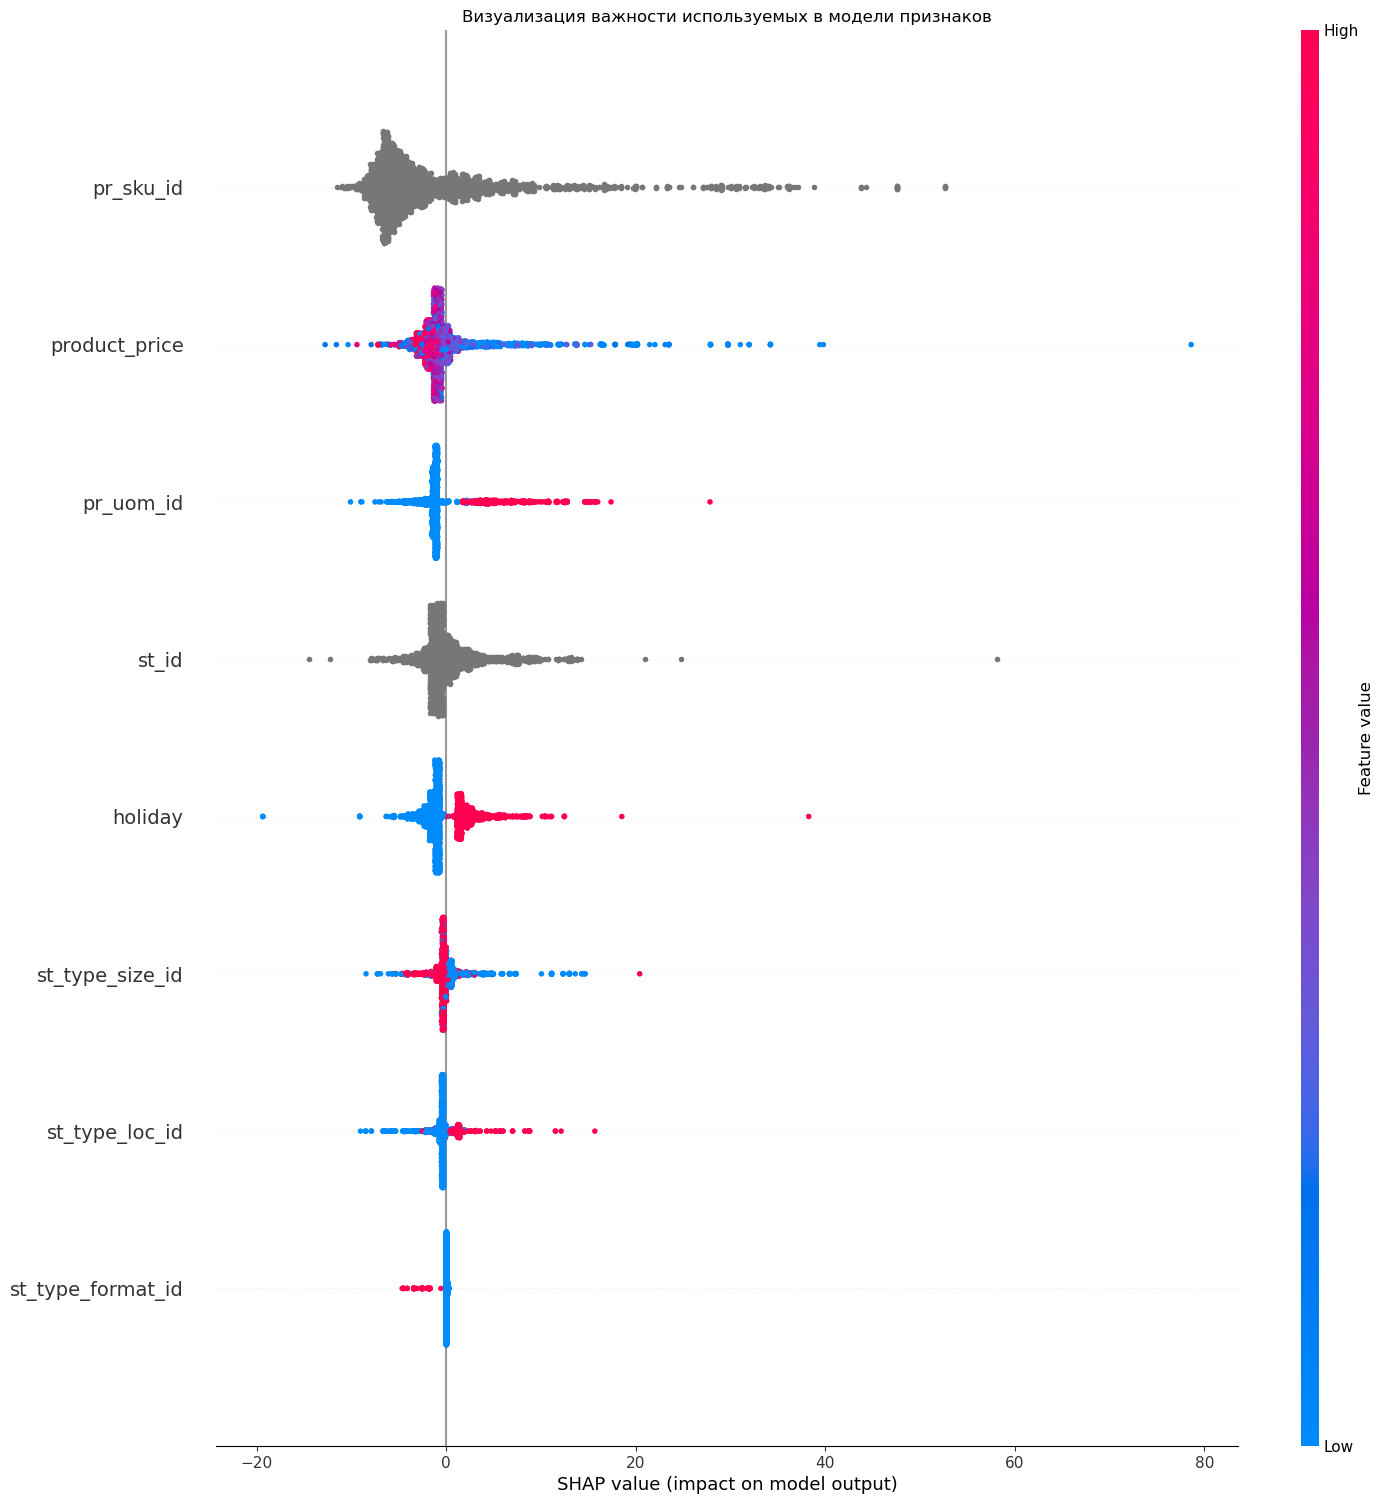

In [30]:
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(features_test_2)

shap.summary_plot(shap_values, features_test_2, show=False, plot_size=(15, 15))
plt.yticks(fontsize=14)
plt.title("Визуализация важности используемых в модели признаков")
plt.show()

Полученный график график показывает, какие признаки являются наиболее важными, а также их диапазон влияния на датасет, и интерпретируется следующим образом:

- **Наиболее важным признаком является цена за единицу товара (product_price), поскольку она не только в верхней части диаграммы, но влияет на точность прогноза больше остальных (показано цветом). Чуть меньше влияние оказывают признаки размерности товаров (штуки и граммы), праздики (больше покупок) и размер территории магазина** 
- значения упорядочены сверху вниз, вверху являются наиболее важными признаками.
- горизонтальное расположение показывает, привело ли влияние значения этого признака к более точному прогнозу или нет. Значения на горизонтальной оси графика SHAP нормализованы для лучшего сравнения влияния разных признаков.
- толщина линии прямо пропорциональна количеству точек наблюдения;
- для каждой точки цвет показывает, является ли этот объект сильно значимым или слабо значимым для этой строки датасета; чем краснее точки, тем большее значение имеет признак в этой точке.

Загрузим submission файл для тестирования

In [31]:
submission_modified = pd.read_csv("submission_modified.csv")

In [32]:
submission_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3836 entries, 0 to 3835
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               3836 non-null   object 
 1   st_id              3836 non-null   object 
 2   pr_sku_id          3836 non-null   object 
 3   holiday            3836 non-null   int64  
 4   pr_uom_id          3836 non-null   int64  
 5   st_type_format_id  3836 non-null   int64  
 6   st_type_loc_id     3836 non-null   int64  
 7   st_type_size_id    3836 non-null   int64  
 8   product_price      3836 non-null   float64
dtypes: float64(1), int64(5), object(3)
memory usage: 269.8+ KB


In [33]:
submission_modified['date'] = pd.to_datetime(submission_modified['date'])
submission_modified = submission_modified.set_index('date')
submission_modified.sort_index(inplace = True)
submission_modified.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3836 entries, 2023-07-19 to 2023-08-01
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   st_id              3836 non-null   object 
 1   pr_sku_id          3836 non-null   object 
 2   holiday            3836 non-null   int64  
 3   pr_uom_id          3836 non-null   int64  
 4   st_type_format_id  3836 non-null   int64  
 5   st_type_loc_id     3836 non-null   int64  
 6   st_type_size_id    3836 non-null   int64  
 7   product_price      3836 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 269.7+ KB


In [34]:
cat_features = ['st_id', 'pr_sku_id']

for col in cat_features:
    submission_modified[col] = submission_modified[col].astype('category')
    
submission_modified.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3836 entries, 2023-07-19 to 2023-08-01
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   st_id              3836 non-null   category
 1   pr_sku_id          3836 non-null   category
 2   holiday            3836 non-null   int64   
 3   pr_uom_id          3836 non-null   int64   
 4   st_type_format_id  3836 non-null   int64   
 5   st_type_loc_id     3836 non-null   int64   
 6   st_type_size_id    3836 non-null   int64   
 7   product_price      3836 non-null   float64 
dtypes: category(2), float64(1), int64(5)
memory usage: 220.1 KB


In [35]:
predictions_submission = np.round(best_model.predict(submission_modified))
predictions_submission

array([ 5., 23.,  8., ...,  2.,  6.,  4.])

In [38]:
submission_modified['target'] = predictions_submission

In [39]:
submission_predictions_only =  submission_modified.drop([
    'holiday', 'pr_uom_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'product_price'], axis=1)
submission_predictions_only.head()

,st_id,pr_sku_id,target
date,,,
2023-07-19,42a0e188f5033bc65bf8d78622277c4e,58ebafabd92e2e3a80d86b7bb7e88eda,5.0
2023-07-19,c81e728d9d4c2f636f067f89cc14862c,cf91eca9321c9c272fb4e7cf4bcc6a43,23.0
2023-07-19,42a0e188f5033bc65bf8d78622277c4e,5d560ea997068115892d2f0bd7cf91c3,8.0
2023-07-19,c81e728d9d4c2f636f067f89cc14862c,0a68dd43c227b0e66d52665d6c3ca8ba,5.0
2023-07-19,fa7cdfad1a5aaf8370ebeda47a1ff1c3,0a2090e24b6ae62b0b0fcaa67a72b5a0,10.0


In [41]:
submission_predictions_only.to_csv('submission_predictions_only.csv')

**ВЫВОД:**

*Что сделано:*  
- Написаны функции для разбиения датасета на пять выборок, состоящих из обучающей, валидационной и тренировочной выборки каждая. Получены пять ступений со скользящим окном в 14 дней. Каждая тестовая и валидационная выборка содержит 14 дней, остальная часть датасета (большая) отдана на обучающую выборку. 
- осуществлена кросс-валидация и подбор гиперпараметров с помощью optuna. 
- По результатам подобрана и обучена лучшая модель. 
- Получены предсказания на лучшей модели для submission выборки, файл заполнен и сохранен в формате, указанном в ТЗ.

*Результат:*
- **WAPE лучшей модели равно 0.3944** что означает, что средняя абсолютная процентная **ошибка составляет примерно 39,4%**. WAPE измеряет точность модели в процентах, и чем ниже значение WAPE, тем лучше.